# **3D Head and Neck Tumor Segmentation (HNTS) using 3D Swin UNETR**

**Import necessary libraries**

In [24]:
# Standard Library Imports
import os
import shutil
import tempfile
import urllib.request
import zipfile

# Data Processing & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm

# PyTorch & Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Medical Imaging Libraries
import nibabel as nib

# MONAI (Medical Open Network for AI)
from monai.config import print_config
from monai.data import (
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
    ThreadDataLoader,
)
from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
)
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.networks.layers import Norm

**Seed for Reproducibility**

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    import random
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

# Apply seeding
set_seed(0)

**Paramters**

In [ ]:
# Paths
DATA_PATH = '/cluster/projects/vc/data/mic/open/HNTS-MRG'
ZIP_FILE = os.path.join(DATA_PATH, 'HNTSMRG24_train.zip')
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/tdt17_mini_project/TDT17_mini_project/Data'
TRAIN_DIR = os.path.join(EXTRACTED_PATH, 'HNTSMRG24_train')

# Training Parameters
BATCH_SIZE_TRAIN = 3               # Number of samples per training batch
NUM_WORKERS = 4                    # Number of subprocesses for data loading
NUM_EPOCHS = 250                    # Total number of training epochs
LEARNING_RATE = 1e-4               # Initial learning rate for optimizer
WEIGHT_DECAY = 1e-5                # Weight decay for optimizer
NUM_CLASSES = 3                    # Number of output classes (Background, GTVp, GTVn)
NUM_SAMPLES = 4                    # Number of samples
ACCUMULATION_STEPS = 4             # Gradient accumulation steps. Used for simulate larger batch

# Learning Rate Scheduler Parameters
SCHEDULER_FACTOR = 0.5             # Factor used to reduce learning rate
SCHEDULER_PATIENCE = 12             # Epochs without improvement before changing learning rate
SCHEDULER_MIN_LR = 1e-6            # Lowest possible learning rate

# Device Configuration
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

# **Step 1: Load Data**

In [4]:
def extract_data(zip_file, extract_path):
    """
    Extracts preRT files from the dataset zip.
    """

    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        preRT_files = [f for f in zip_ref.namelist() if '/preRT/' in f]
        zip_ref.extractall(path=extract_path, members=preRT_files)
    print(f"Data extracted to {extract_path}")

# Extract data
extract_data(ZIP_FILE, EXTRACTED_PATH)

Data extracted to /cluster/home/bjorneme/projects/tdt17_mini_project/TDT17_mini_project/Data


# **Step 2: Exploratory Data Analysis**

**Count number of patients**

In [5]:
# Path to the training data
train_dir = os.path.join(EXTRACTED_PATH, 'HNTSMRG24_train')

# List all patient folders
patient_folders = os.listdir(TRAIN_DIR)
print(f"Total patients extracted: {len(patient_folders)}")

Total patients extracted: 150


**Prepare EDA**

In [6]:
# Initialize lists to store image information
dimensions = []
voxel_sizes = []
intensities = []
mask_voxel_counts = []

for patient_id in patient_folders:

    mri_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    
    # Load MRI and mask
    mri_img = nib.load(mri_path)
    mask_img = nib.load(mask_path)
    
    # Get data arrays
    mri_data = mri_img.get_fdata()
    mask_data = mask_img.get_fdata()
    
    # Collect image dimensions and voxel sizes
    dimensions.append(mri_data.shape)
    voxel_sizes.append(mri_img.header.get_zooms())
    
    # Collect intensity statistics
    intensities.append({
        'mean': np.mean(mri_data),
        'std': np.std(mri_data),
        'min': np.min(mri_data),
        'max': np.max(mri_data),
    })
    
    # Count the number of voxels in each class
    unique, counts = np.unique(mask_data, return_counts=True)
    mask_voxel_counts.append(dict(zip(unique.astype(int), counts)))

**EDA: Image Dimensions**

In [7]:
# Convert dimensions to a NumPy array
dimensions_array = np.array(dimensions)

# Calculate min, max, and mean dimensions
min_dims = dimensions_array.min(axis=0)
max_dims = dimensions_array.max(axis=0)
mean_dims = dimensions_array.mean(axis=0)

# Create a DataFrame for the results
data = {
    "Statistic": ["Minimum", "Maximum", "Mean (rounded)"],
    "Width": [min_dims[0], max_dims[0], mean_dims[0]],
    "Height": [min_dims[1], max_dims[1], mean_dims[1]],
    "Depth": [min_dims[2], max_dims[2], mean_dims[2]]
}

# Display as dataframe
pd.DataFrame(data)

,Statistic,Width,Height,Depth
0,Minimum,512.000000,480.00,57.00
1,Maximum,768.000000,768.00,162.00
2,Mean (rounded),523.306667,522.88,84.04


**EDA: Tumor Sizes**

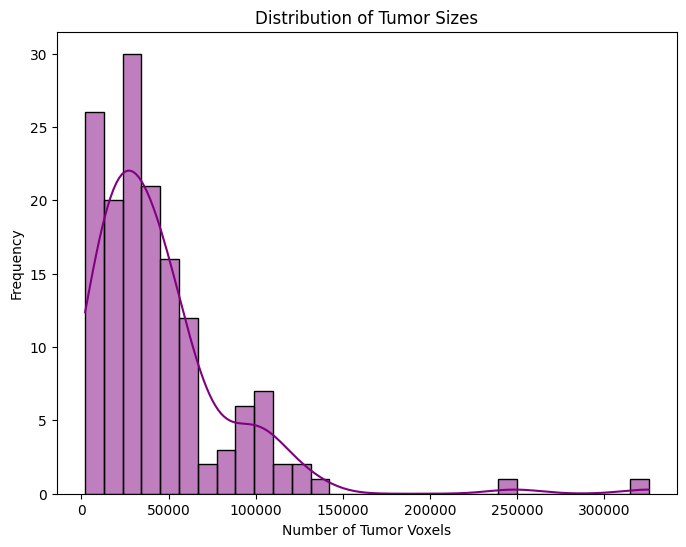

In [8]:
# Calculate tumor sizes
tumor_sizes = [counts.get(1, 0) + counts.get(2, 0) for counts in mask_voxel_counts]

# Plot distribution
plt.figure(figsize=(8, 6))
sns.histplot(tumor_sizes, bins=30, kde=True, color='purple')
plt.title('Distribution of Tumor Sizes')
plt.xlabel('Number of Tumor Voxels')
plt.ylabel('Frequency')
plt.show()

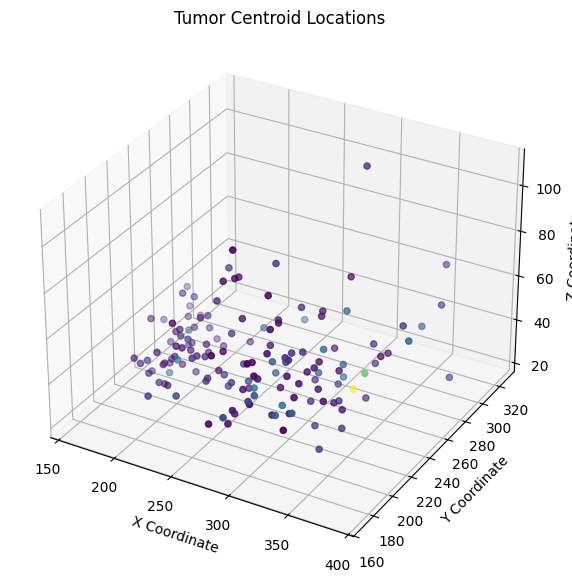

In [9]:
# Initialize lists
tumor_sizes = []
tumor_locations = []

for patient_id in patient_folders:
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    mask_img = nib.load(mask_path)
    mask_data = mask_img.get_fdata().astype(int)

    # Calculate tumor size (number of voxels in tumor classes)
    tumor_voxels = mask_data > 0
    size = np.sum(tumor_voxels)
    tumor_sizes.append(size)

    # Calculate tumor centroid
    coords = np.column_stack(np.where(mask_data > 0))
    if coords.size > 0:
        centroid = coords.mean(axis=0)
        tumor_locations.append(centroid)
    else:
        tumor_locations.append([np.nan, np.nan, np.nan])

# Convert to DataFrame
eda_df = pd.DataFrame({
    'Patient_ID': patient_folders,
    'Tumor_Size': tumor_sizes,
    'Centroid_X': [loc[0] for loc in tumor_locations],
    'Centroid_Y': [loc[1] for loc in tumor_locations],
    'Centroid_Z': [loc[2] for loc in tumor_locations],
})

# 3D Scatter plot of tumor centroids
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(eda_df['Centroid_X'], eda_df['Centroid_Y'], eda_df['Centroid_Z'], c=eda_df['Tumor_Size'])
ax.set_title('Tumor Centroid Locations')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.show()

**EDA: Understand class distribution (Background, GTVp, GTVn)**

In [10]:
# Aggregate mask voxel counts
class_counts = {}
for counts in mask_voxel_counts:
    for k, v in counts.items():
        class_counts[k] = class_counts.get(k, 0) + v

# Calculate total voxels
total_voxels = sum(class_counts.values())

# Calculate percentages
class_percentages = {int(k): (v / total_voxels) * 100 for k, v in class_counts.items()}

# Define class labels
class_labels = {
    0: 'Background',
    1: 'GTVp',
    2: 'GTVn'
}

# Create a DataFrame for class distribution
class_df = pd.DataFrame({
    'Class': [class_labels.get(cls, f'Class {cls}') for cls in class_percentages.keys()],
    'Percentage (%)': [round(pct, 4) for pct in class_percentages.values()]
})

# Display the DataFrame
class_df

,Class,Percentage (%)
0,Background,99.8107
1,GTVp,0.0862
2,GTVn,0.1031


**EDA: Plot samples to check quality and type of data**

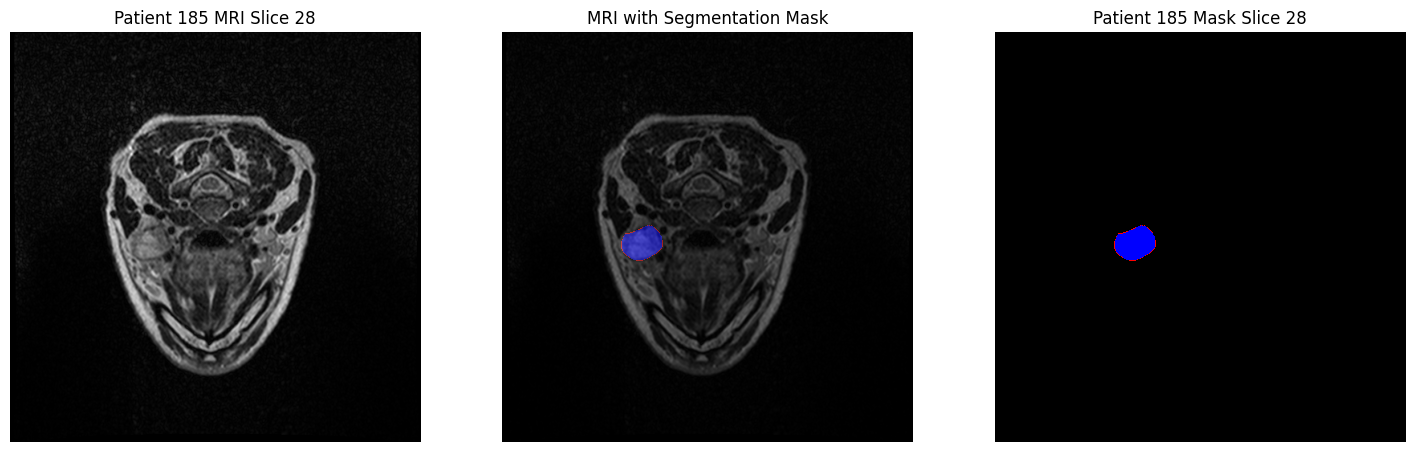

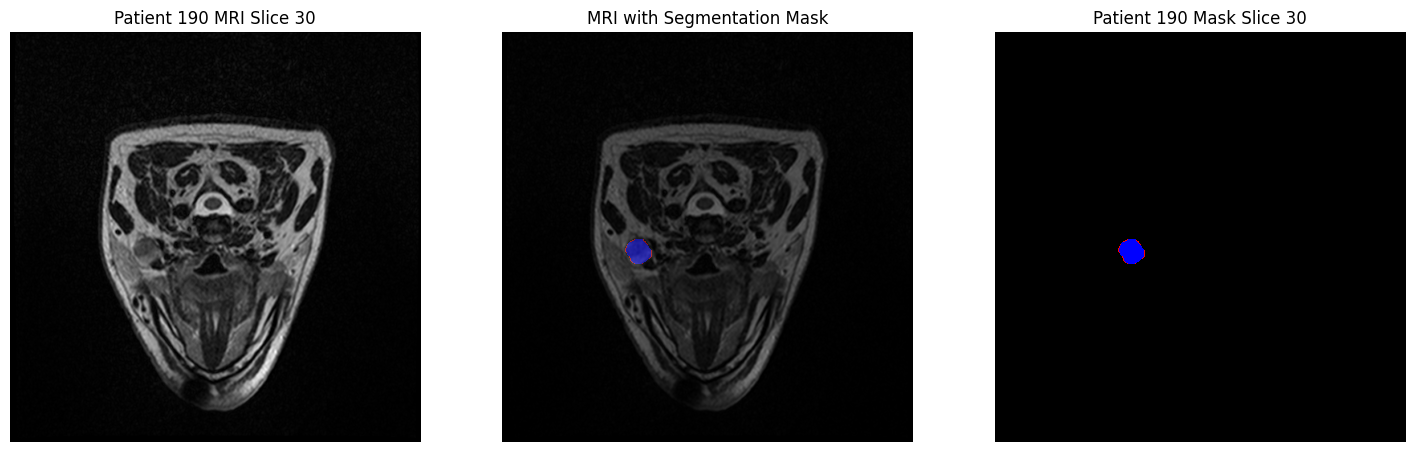

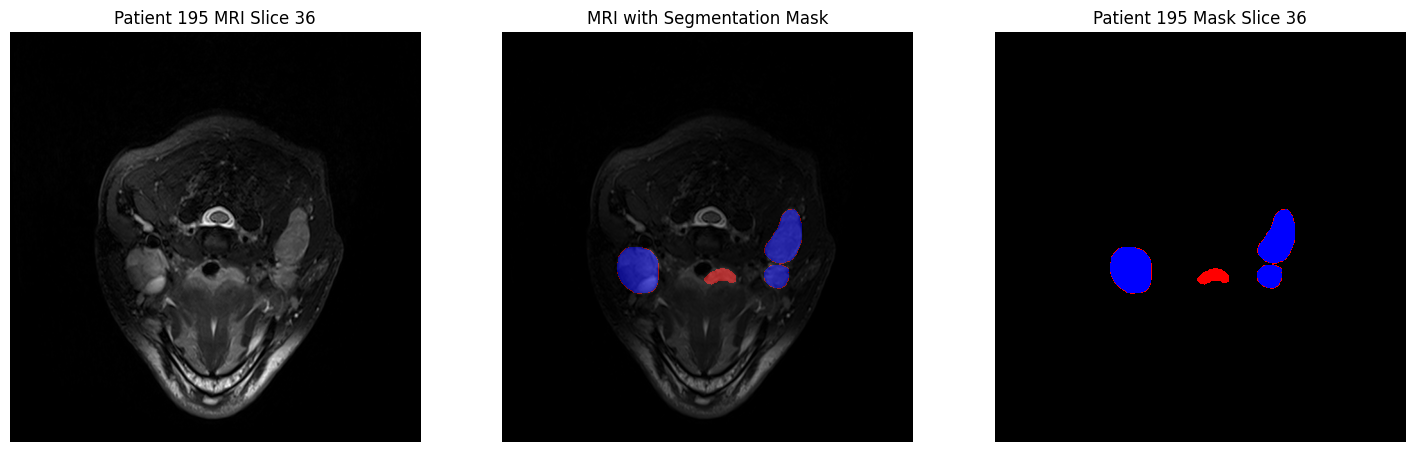

In [11]:
def plot_sample(patient_id, slice_index=None):
    # Define paths
    mri_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    
    # Load data
    mri_data = nib.load(mri_path).get_fdata()
    mask_data = nib.load(mask_path).get_fdata().astype(int)
    
    # Select the middle slice
    slice_index = mri_data.shape[2] // 2
    mri_slice = mri_data[:, :, slice_index].T
    mask_slice = mask_data[:, :, slice_index].T
    
    # Define colormap for mask
    cmap = colors.ListedColormap(['black', 'red', 'blue'])
    norm = colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. MRI Image
    axes[0].imshow(mri_slice, cmap='gray', origin='lower')
    axes[0].set_title(f'Patient {patient_id} MRI Slice {slice_index}')
    axes[0].axis('off')
    
    # 2. MRI with Mask Overlay
    axes[1].imshow(mri_slice, cmap='gray', origin='lower')
    axes[1].imshow(mask_slice, cmap=cmap, norm=norm, alpha=0.5, origin='lower')
    axes[1].set_title('MRI with Segmentation Mask')
    axes[1].axis('off')
    
    # 3. Mask Only
    im = axes[2].imshow(mask_slice, cmap=cmap, norm=norm, origin='lower')
    axes[2].set_title(f'Patient {patient_id} Mask Slice {slice_index}')
    axes[2].axis('off')

    plt.show()

# Plot samples from a few patients
patient_ids = ['185', '190', '195']
for pid in patient_ids:
    plot_sample(pid)

# **Step 3: Data Preprocessing**

**Create data dictionary**

In [12]:
def create_data_dicts(train_dir):
    """
    Creates data dictionaries for MONAI.
    """
    data_dicts = [
        {
            "image": os.path.join(train_dir, pid, 'preRT', f'{pid}_preRT_T2.nii.gz'),
            "label": os.path.join(train_dir, pid, 'preRT', f'{pid}_preRT_mask.nii.gz'),
        }
        for pid in patient_folders
    ]
    return data_dicts

# Create data dictionaries
data_dicts = create_data_dicts(TRAIN_DIR)

**Split the dataset into training and validation (80/20)**

In [13]:
# Split data into training and validation sets
train_files = data_dicts[:120]
val_files = data_dicts[120:]
print(f"Training samples: {len(train_files)}, Validation samples: {len(val_files)}")

Training samples: 120, Validation samples: 30


**Transform images**

In [14]:
# Transform the images for training
train_transforms = Compose(
    [
        # Load images and labels
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),

        # Scale image intensity
            ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),

        # Crop to remove background
        CropForegroundd(keys=["image", "label"], source_key="image"),

        # Reorient to RAS standard
        Orientationd(keys=["image", "label"], axcodes="RAS"),

        # Resample to target spacing
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),

        # Convert to PyTorch tensors
        EnsureTyped(keys=["image", "label"], device=device, track_meta=False),

        # Randomly crop based on labels
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 32),
            pos=1,
            neg=1,
            num_samples=NUM_SAMPLES,
            image_key="image",
            image_threshold=0,
        ),
        
        # Apply random flips
        RandFlipd(keys=["image", "label"], spatial_axis=[0], prob=0.10),
        RandFlipd(keys=["image", "label"], spatial_axis=[1], prob=0.10),
        RandFlipd(keys=["image", "label"], spatial_axis=[2], prob=0.10),

        # Apply random rotations
        RandRotate90d(keys=["image", "label"], prob=0.10, max_k=3),

        # Random intensity shift
        RandShiftIntensityd(keys=["image"], offsets=0.10, prob=0.50),
    ]
)

# Transform the images for validation
val_transforms = Compose(
    [
        # Load images and labels
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),

        # Scale image intensity
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),

        # Crop to remove background
        CropForegroundd(keys=["image", "label"], source_key="image"),

        # Reorient to RAS standard
        Orientationd(keys=["image", "label"], axcodes="RAS"),

        # Resample to target spacing
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),

        # Convert to PyTorch tensors
        EnsureTyped(keys=["image", "label"], device=device, track_meta=True),
    ]
)

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


**Create datasets**

In [15]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0)

Loading dataset: 100%|██████████| 30/30 [00:58<00:00,  1.93s/it]


**Create DataLoaders**

In [16]:
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=3, shuffle=True)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)


Train Batch 1:


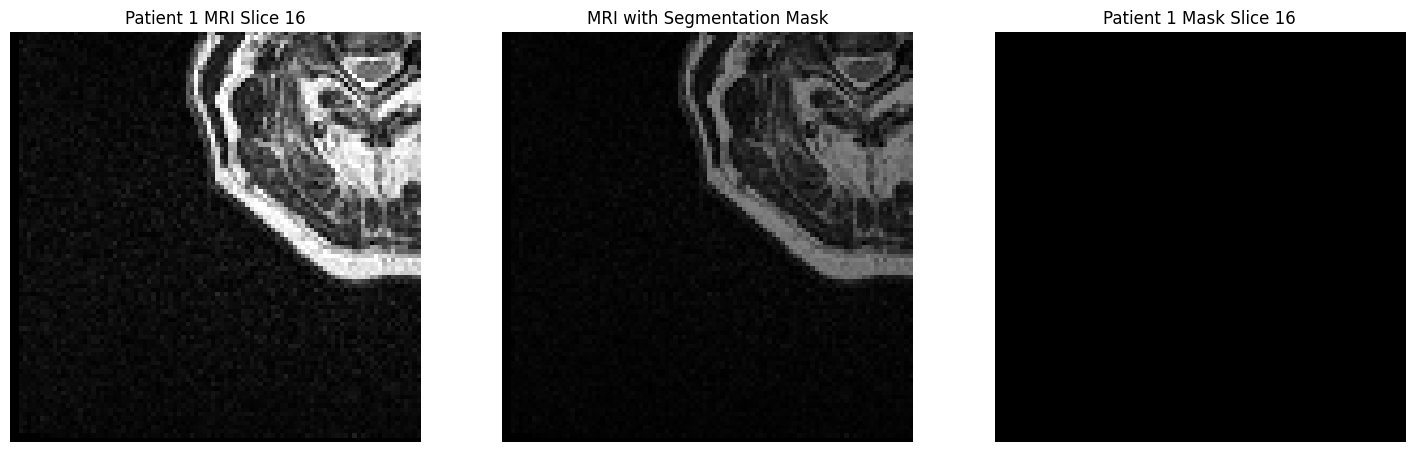

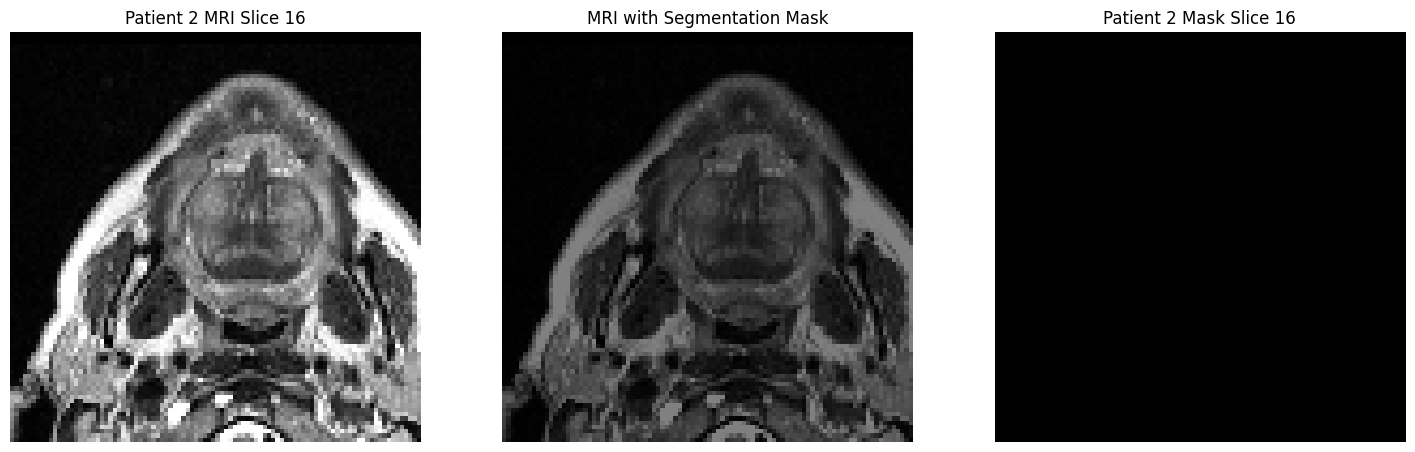


Train Batch 2:


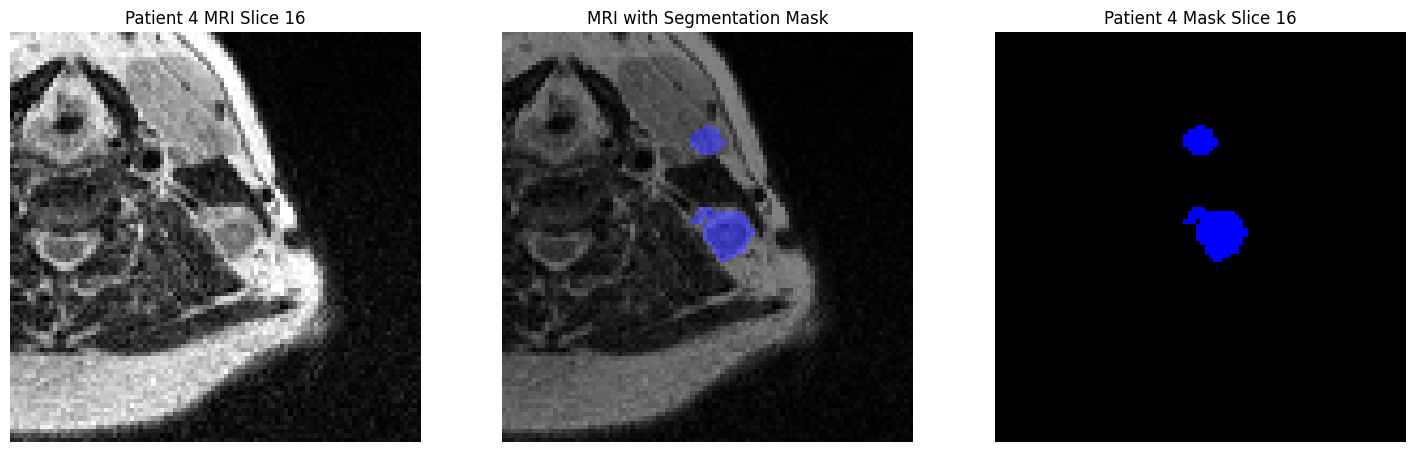

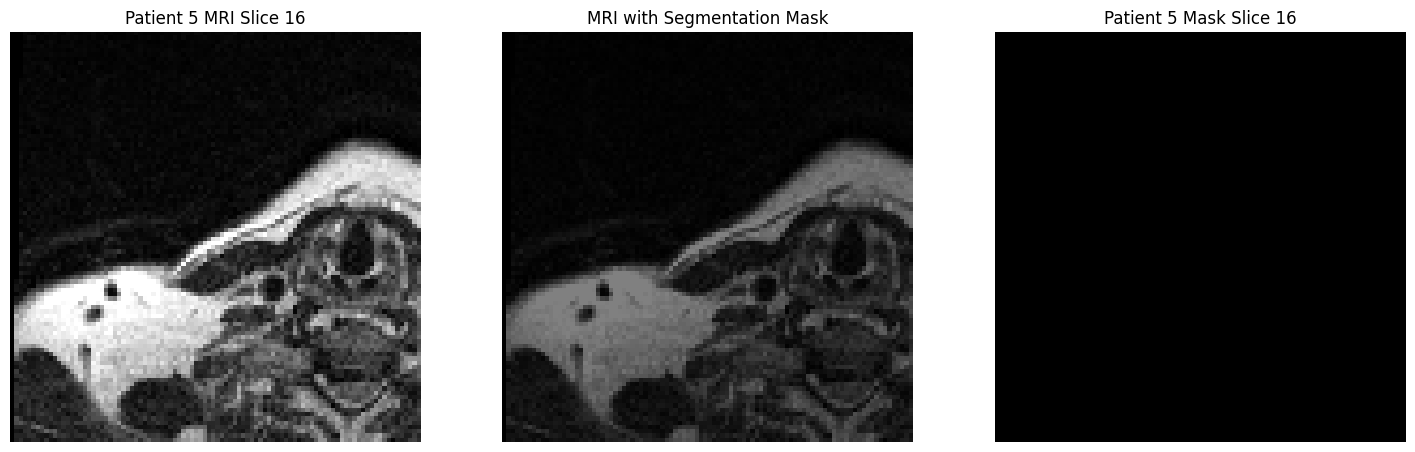


Validation Batch 1:


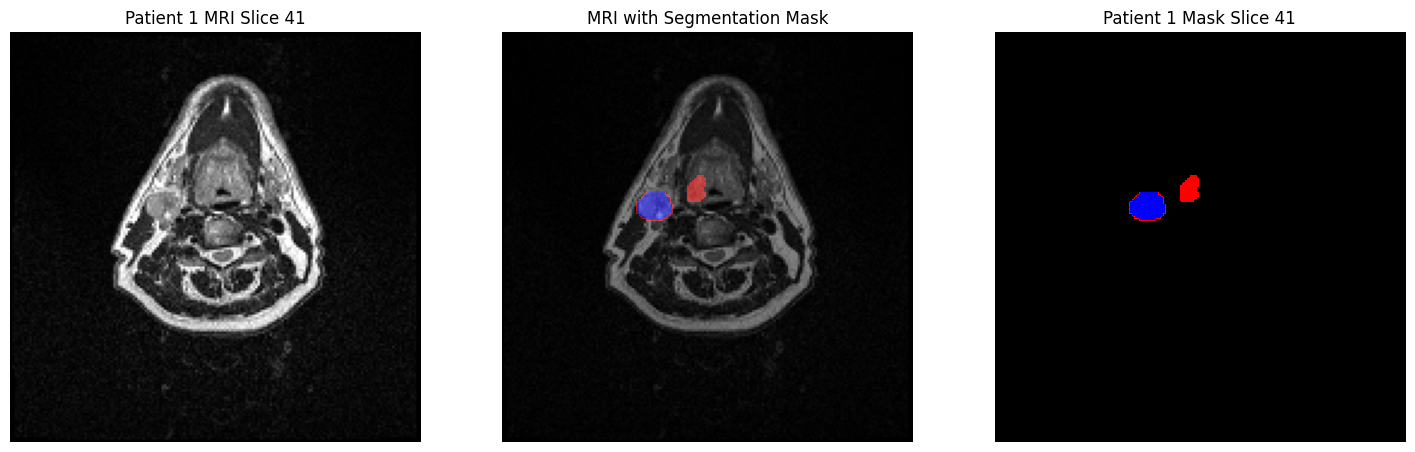

In [17]:
def plot_dataloader_sample(image_tensor, label_tensor, patient_id=None, slice_index=None):
    """
    Plots MRI image, MRI with segmentation mask overlay, and mask only.
    """
    image_np = image_tensor.cpu().numpy()
    label_np = label_tensor.cpu().numpy()

    if image_np.shape[0] == 1:
        image_np = np.squeeze(image_np, axis=0)

    if label_np.ndim == 4 and label_np.shape[0] == 1:
        label_np = np.squeeze(label_np, axis=0)

    if slice_index is None:
        slice_index = image_np.shape[2] // 2

    mri_slice = image_np[:, :, slice_index].T
    mask_slice = label_np[:, :, slice_index].T

    cmap = colors.ListedColormap(['black', 'red', 'blue'])
    norm = colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(mri_slice, cmap='gray', origin='lower')
    title1 = f'Patient {patient_id} MRI Slice {slice_index}' if patient_id else f'MRI Slice {slice_index}'
    axes[0].set_title(title1)
    axes[0].axis('off')

    axes[1].imshow(mri_slice, cmap='gray', origin='lower')
    axes[1].imshow(mask_slice, cmap=cmap, norm=norm, alpha=0.5, origin='lower')
    axes[1].set_title('MRI with Segmentation Mask')
    axes[1].axis('off')

    axes[2].imshow(mask_slice, cmap=cmap, norm=norm, origin='lower')
    title3 = f'Patient {patient_id} Mask Slice {slice_index}' if patient_id else f'Mask Slice {slice_index}'
    axes[2].set_title(title3)
    axes[2].axis('off')

    plt.show()

def visualize_dataloader_samples(dataloader, num_batches=1, samples_per_batch=2, mode='Train'):
    """
    Visualizes samples from the dataloader.
    """
    for batch_idx, batch_data in enumerate(dataloader):
        if batch_idx >= num_batches:
            break

        images = batch_data["image"]
        labels = batch_data["label"]

        batch_size = images.shape[0]
        print(f"\n{mode} Batch {batch_idx + 1}:")
        for i in range(min(samples_per_batch, batch_size)):
            image = images[i]
            label = labels[i]
            patient_id = f"{batch_idx * dataloader.batch_size + i + 1}"
            plot_dataloader_sample(image, label, patient_id=patient_id)

# Example visualization
visualize_dataloader_samples(train_loader, num_batches=2, samples_per_batch=2, mode='Train')
visualize_dataloader_samples(val_loader, num_batches=1, samples_per_batch=1, mode='Validation')

**Prepare for usage of GPU**

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Step 5: Build Model**

**Initialize UNET Model**

In [25]:
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels=(32, 64, 128, 256, 512),
    strides= (2, 2, 2, 2, 2),
    num_res_units=5,
    dropout=0.35,
    norm=Norm.BATCH,
).to(device)

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/monai/networks/nets/unet.py:130: UserWarning: `len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")


# **Step 6: Train and Validate Model**

**Define Loss, Optimizer, and Metrics**

In [26]:
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scaler = torch.cuda.amp.GradScaler()

post_label = AsDiscrete(to_onehot=NUM_CLASSES)
post_pred = AsDiscrete(argmax=True, to_onehot=NUM_CLASSES)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

/tmp/ipykernel_3325219/567529329.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


**Training Loop**

In [27]:
# Post-processing for metrics
post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot=3)

# Initialize Dice metric
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

# Initialize lists to store loss values
train_losses = []
val_losses = []
dice_scores = []

best_dice = 0.0  # Initialize best Dice score
best_epoch = 0  # To track which epoch had the best Dice score

# Initialize the scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',  # Because higher Dice score is better
    factor=SCHEDULER_FACTOR,
    patience=SCHEDULER_PATIENCE,
    verbose=True,
    min_lr=SCHEDULER_MIN_LR
)

# Training Loop
for epoch in range(NUM_EPOCHS):

    # ----------- Training Phase -----------
    model.train()
    epoch_loss = 0.0
    step = 0
    progress_bar = tqdm(train_loader, desc=f"Training epoch {epoch+1}/{NUM_EPOCHS}")

    for batch_data in progress_bar:
        step += 1

        # Retrieve training samples
        inputs = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        with torch.amp.autocast(str(device)):

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = loss_function(outputs, labels) / ACCUMULATION_STEPS

        # Backward pass
        scaler.scale(loss).backward()

        # Calculate epoch loss
        epoch_loss += loss.item() * ACCUMULATION_STEPS

        if step % ACCUMULATION_STEPS == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        # Update progress bar
        progress_bar.set_postfix({"Loss": loss.item()*ACCUMULATION_STEPS})

    # Calculate average epoch loss
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)


    # ----------- Validation Phase -----------
    model.eval()
    val_loss = 0.0
    dice_metric.reset()
    progress_bar = tqdm(val_loader, desc=f"Validation epoch {epoch+1}/{NUM_EPOCHS}")

    with torch.no_grad():
        for val_batch in progress_bar:

            # Retrieve validation samples
            val_inputs = val_batch["image"].cuda()
            val_labels = val_batch["label"].cuda()

            with torch.amp.autocast(str(device)):
                # Forward pass with sliding window inference for large images
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)

                # Compute validation loss
                loss = loss_function(val_outputs, val_labels)
                val_loss += loss.item()

            # Post-processing for Dice metric
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)

            # Update progress bar
            progress_bar.set_postfix({"Loss": loss.item()})
    
    # Calculate average validation loss and Dice score for the epoch
    avg_val_loss = val_loss / len(val_loader)
    dice_score = dice_metric.aggregate().item()
    dice_metric.reset()

    # Save losses
    val_losses.append(avg_val_loss)
    dice_scores.append(dice_score)

    # Step the scheduler based on validation Dice score
    scheduler.step(dice_score)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], "
          f"Train Loss: {avg_epoch_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Dice Score: {dice_score:.4f}")


    # ----------- Model Checkpointing -----------
    if dice_score > best_dice:
        best_dice = dice_score
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
        print(f"New best Dice score! Model saved at epoch {best_epoch} with Dice: {best_dice:.4f}")
    else:
        print(f"No improvement in Dice score this epoch.")


/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Validation epoch 1/250: 100%|██████████| 30/30 [00:08<00:00,  3.73it/s, Loss=1.79]


Epoch [1/250], Train Loss: 1.8416, Val Loss: 1.5560, Dice Score: 0.3513
New best Dice score! Model saved at epoch 1 with Dice: 0.3513


Validation epoch 2/250: 100%|██████████| 30/30 [00:02<00:00, 10.05it/s, Loss=1.27]


Epoch [2/250], Train Loss: 1.5297, Val Loss: 1.2584, Dice Score: 0.3728
New best Dice score! Model saved at epoch 2 with Dice: 0.3728


Validation epoch 3/250: 100%|██████████| 30/30 [00:03<00:00,  9.70it/s, Loss=1.03] 


Epoch [3/250], Train Loss: 1.2945, Val Loss: 1.0140, Dice Score: 0.3725
No improvement in Dice score this epoch.


Validation epoch 4/250: 100%|██████████| 30/30 [00:02<00:00, 10.10it/s, Loss=0.868]


Epoch [4/250], Train Loss: 1.0946, Val Loss: 0.8758, Dice Score: 0.3719
No improvement in Dice score this epoch.


Validation epoch 5/250: 100%|██████████| 30/30 [00:04<00:00,  6.25it/s, Loss=0.767]


Epoch [5/250], Train Loss: 0.9417, Val Loss: 0.7742, Dice Score: 0.3719
No improvement in Dice score this epoch.


Validation epoch 6/250: 100%|██████████| 30/30 [00:04<00:00,  6.39it/s, Loss=0.726]


Epoch [6/250], Train Loss: 0.8556, Val Loss: 0.7315, Dice Score: 0.3719
No improvement in Dice score this epoch.


Validation epoch 7/250: 100%|██████████| 30/30 [00:03<00:00,  7.53it/s, Loss=0.71] 


Epoch [7/250], Train Loss: 0.8078, Val Loss: 0.7129, Dice Score: 0.3719
No improvement in Dice score this epoch.


Validation epoch 8/250: 100%|██████████| 30/30 [00:04<00:00,  6.25it/s, Loss=0.697]


Epoch [8/250], Train Loss: 0.7801, Val Loss: 0.7003, Dice Score: 0.3719
No improvement in Dice score this epoch.


Validation epoch 9/250: 100%|██████████| 30/30 [00:03<00:00,  7.52it/s, Loss=0.687]


Epoch [9/250], Train Loss: 0.7654, Val Loss: 0.6916, Dice Score: 0.3719
No improvement in Dice score this epoch.


Validation epoch 10/250: 100%|██████████| 30/30 [00:04<00:00,  6.67it/s, Loss=0.687]


Epoch [10/250], Train Loss: 0.7527, Val Loss: 0.6923, Dice Score: 0.3719
No improvement in Dice score this epoch.


Validation epoch 11/250: 100%|██████████| 30/30 [00:04<00:00,  6.53it/s, Loss=0.675]


Epoch [11/250], Train Loss: 0.7460, Val Loss: 0.6829, Dice Score: 0.3719
No improvement in Dice score this epoch.


Validation epoch 12/250: 100%|██████████| 30/30 [00:04<00:00,  6.13it/s, Loss=0.703]


Epoch [12/250], Train Loss: 0.7402, Val Loss: 0.6877, Dice Score: 0.3722
No improvement in Dice score this epoch.


Validation epoch 13/250: 100%|██████████| 30/30 [00:04<00:00,  6.22it/s, Loss=0.674]


Epoch [13/250], Train Loss: 0.7354, Val Loss: 0.6792, Dice Score: 0.3719
No improvement in Dice score this epoch.


Validation epoch 14/250: 100%|██████████| 30/30 [00:04<00:00,  6.18it/s, Loss=0.693]


Epoch [14/250], Train Loss: 0.7327, Val Loss: 0.6983, Dice Score: 0.3719
No improvement in Dice score this epoch.


Validation epoch 15/250: 100%|██████████| 30/30 [00:04<00:00,  6.67it/s, Loss=0.677]


Epoch [15/250], Train Loss: 0.7243, Val Loss: 0.6845, Dice Score: 0.3719
No improvement in Dice score this epoch.


Validation epoch 16/250: 100%|██████████| 30/30 [00:04<00:00,  6.19it/s, Loss=0.696]


Epoch [16/250], Train Loss: 0.7219, Val Loss: 0.6829, Dice Score: 0.3724
No improvement in Dice score this epoch.


Validation epoch 17/250: 100%|██████████| 30/30 [00:04<00:00,  6.21it/s, Loss=0.674]


Epoch [17/250], Train Loss: 0.7164, Val Loss: 0.6727, Dice Score: 0.3749
New best Dice score! Model saved at epoch 17 with Dice: 0.3749


Validation epoch 18/250: 100%|██████████| 30/30 [00:04<00:00,  6.67it/s, Loss=0.689]


Epoch [18/250], Train Loss: 0.7147, Val Loss: 0.6894, Dice Score: 0.3893
New best Dice score! Model saved at epoch 18 with Dice: 0.3893


Validation epoch 19/250: 100%|██████████| 30/30 [00:04<00:00,  6.61it/s, Loss=0.675]


Epoch [19/250], Train Loss: 0.7162, Val Loss: 0.6706, Dice Score: 0.3755
No improvement in Dice score this epoch.


Validation epoch 20/250: 100%|██████████| 30/30 [00:04<00:00,  6.35it/s, Loss=0.674]


Epoch [20/250], Train Loss: 0.7117, Val Loss: 0.6756, Dice Score: 0.3719
No improvement in Dice score this epoch.


Validation epoch 21/250: 100%|██████████| 30/30 [00:04<00:00,  6.23it/s, Loss=0.677]


Epoch [21/250], Train Loss: 0.7135, Val Loss: 0.6699, Dice Score: 0.3812
No improvement in Dice score this epoch.


Validation epoch 22/250: 100%|██████████| 30/30 [00:04<00:00,  6.34it/s, Loss=0.676]


Epoch [22/250], Train Loss: 0.7066, Val Loss: 0.6831, Dice Score: 0.3719
No improvement in Dice score this epoch.


Validation epoch 23/250: 100%|██████████| 30/30 [00:04<00:00,  6.29it/s, Loss=0.736]


Epoch [23/250], Train Loss: 0.7030, Val Loss: 0.6940, Dice Score: 0.3985
New best Dice score! Model saved at epoch 23 with Dice: 0.3985


Validation epoch 24/250: 100%|██████████| 30/30 [00:04<00:00,  6.29it/s, Loss=0.672]


Epoch [24/250], Train Loss: 0.7024, Val Loss: 0.6696, Dice Score: 0.3736
No improvement in Dice score this epoch.


Validation epoch 25/250: 100%|██████████| 30/30 [00:04<00:00,  6.30it/s, Loss=0.676]


Epoch [25/250], Train Loss: 0.7036, Val Loss: 0.6772, Dice Score: 0.3800
No improvement in Dice score this epoch.


Validation epoch 26/250: 100%|██████████| 30/30 [00:04<00:00,  6.37it/s, Loss=0.689]


Epoch [26/250], Train Loss: 0.6960, Val Loss: 0.6790, Dice Score: 0.4085
New best Dice score! Model saved at epoch 26 with Dice: 0.4085


Validation epoch 27/250: 100%|██████████| 30/30 [00:04<00:00,  6.40it/s, Loss=0.672]


Epoch [27/250], Train Loss: 0.6990, Val Loss: 0.6742, Dice Score: 0.3728
No improvement in Dice score this epoch.


Validation epoch 28/250: 100%|██████████| 30/30 [00:04<00:00,  6.16it/s, Loss=0.678]


Epoch [28/250], Train Loss: 0.6941, Val Loss: 0.6766, Dice Score: 0.3878
No improvement in Dice score this epoch.


Validation epoch 29/250: 100%|██████████| 30/30 [00:04<00:00,  6.38it/s, Loss=0.695]


Epoch [29/250], Train Loss: 0.6936, Val Loss: 0.6862, Dice Score: 0.4201
New best Dice score! Model saved at epoch 29 with Dice: 0.4201


Validation epoch 30/250: 100%|██████████| 30/30 [00:04<00:00,  6.62it/s, Loss=0.691]


Epoch [30/250], Train Loss: 0.6927, Val Loss: 0.6809, Dice Score: 0.3984
No improvement in Dice score this epoch.


Validation epoch 31/250: 100%|██████████| 30/30 [00:04<00:00,  6.36it/s, Loss=0.672]


Epoch [31/250], Train Loss: 0.6878, Val Loss: 0.6617, Dice Score: 0.4157
No improvement in Dice score this epoch.


Validation epoch 32/250: 100%|██████████| 30/30 [00:04<00:00,  6.25it/s, Loss=0.662]


Epoch [32/250], Train Loss: 0.6896, Val Loss: 0.6966, Dice Score: 0.3730
No improvement in Dice score this epoch.


Validation epoch 33/250: 100%|██████████| 30/30 [00:04<00:00,  6.23it/s, Loss=0.668]


Epoch [33/250], Train Loss: 0.6882, Val Loss: 0.6897, Dice Score: 0.4064
No improvement in Dice score this epoch.


Validation epoch 34/250: 100%|██████████| 30/30 [00:04<00:00,  6.45it/s, Loss=0.679]


Epoch [34/250], Train Loss: 0.6900, Val Loss: 0.6807, Dice Score: 0.4122
No improvement in Dice score this epoch.


Validation epoch 35/250: 100%|██████████| 30/30 [00:04<00:00,  6.58it/s, Loss=0.691]


Epoch [35/250], Train Loss: 0.6875, Val Loss: 0.6919, Dice Score: 0.3845
No improvement in Dice score this epoch.


Validation epoch 36/250: 100%|██████████| 30/30 [00:04<00:00,  6.35it/s, Loss=0.669]


Epoch [36/250], Train Loss: 0.6914, Val Loss: 0.6619, Dice Score: 0.3802
No improvement in Dice score this epoch.


Validation epoch 37/250: 100%|██████████| 30/30 [00:04<00:00,  6.28it/s, Loss=0.673]


Epoch [37/250], Train Loss: 0.6869, Val Loss: 0.6667, Dice Score: 0.3916
No improvement in Dice score this epoch.


Validation epoch 38/250: 100%|██████████| 30/30 [00:04<00:00,  6.46it/s, Loss=0.681]


Epoch [38/250], Train Loss: 0.6802, Val Loss: 0.6790, Dice Score: 0.4112
No improvement in Dice score this epoch.


Validation epoch 39/250: 100%|██████████| 30/30 [00:04<00:00,  6.32it/s, Loss=0.671]


Epoch [39/250], Train Loss: 0.6848, Val Loss: 0.6536, Dice Score: 0.4163
No improvement in Dice score this epoch.


Validation epoch 40/250: 100%|██████████| 30/30 [00:04<00:00,  6.15it/s, Loss=0.67] 


Epoch [40/250], Train Loss: 0.6784, Val Loss: 0.6654, Dice Score: 0.4345
New best Dice score! Model saved at epoch 40 with Dice: 0.4345


Validation epoch 41/250: 100%|██████████| 30/30 [00:04<00:00,  6.27it/s, Loss=0.657]


Epoch [41/250], Train Loss: 0.6789, Val Loss: 0.6590, Dice Score: 0.3992
No improvement in Dice score this epoch.


Validation epoch 42/250: 100%|██████████| 30/30 [00:04<00:00,  6.83it/s, Loss=0.67] 


Epoch [42/250], Train Loss: 0.6775, Val Loss: 0.6552, Dice Score: 0.4236
No improvement in Dice score this epoch.


Validation epoch 43/250: 100%|██████████| 30/30 [00:04<00:00,  6.39it/s, Loss=0.668]


Epoch [43/250], Train Loss: 0.6803, Val Loss: 0.6767, Dice Score: 0.3856
No improvement in Dice score this epoch.


Validation epoch 44/250: 100%|██████████| 30/30 [00:04<00:00,  6.22it/s, Loss=0.669]


Epoch [44/250], Train Loss: 0.6729, Val Loss: 0.6528, Dice Score: 0.4251
No improvement in Dice score this epoch.


Validation epoch 45/250: 100%|██████████| 30/30 [00:04<00:00,  6.24it/s, Loss=0.658]


Epoch [45/250], Train Loss: 0.6729, Val Loss: 0.6656, Dice Score: 0.3917
No improvement in Dice score this epoch.


Validation epoch 46/250: 100%|██████████| 30/30 [00:04<00:00,  6.59it/s, Loss=0.685]


Epoch [46/250], Train Loss: 0.6699, Val Loss: 0.7082, Dice Score: 0.4169
No improvement in Dice score this epoch.


Validation epoch 47/250: 100%|██████████| 30/30 [00:04<00:00,  6.52it/s, Loss=0.658]


Epoch [47/250], Train Loss: 0.6719, Val Loss: 0.6408, Dice Score: 0.4418
New best Dice score! Model saved at epoch 47 with Dice: 0.4418


Validation epoch 48/250: 100%|██████████| 30/30 [00:04<00:00,  6.30it/s, Loss=0.801]


Epoch [48/250], Train Loss: 0.6789, Val Loss: 0.7405, Dice Score: 0.3745
No improvement in Dice score this epoch.


Validation epoch 49/250: 100%|██████████| 30/30 [00:04<00:00,  6.28it/s, Loss=0.677]


Epoch [49/250], Train Loss: 0.6839, Val Loss: 0.6664, Dice Score: 0.4061
No improvement in Dice score this epoch.


Validation epoch 50/250: 100%|██████████| 30/30 [00:04<00:00,  6.68it/s, Loss=0.658]


Epoch [50/250], Train Loss: 0.6741, Val Loss: 0.6616, Dice Score: 0.4246
No improvement in Dice score this epoch.


Validation epoch 51/250: 100%|██████████| 30/30 [00:04<00:00,  6.45it/s, Loss=0.65] 


Epoch [51/250], Train Loss: 0.6640, Val Loss: 0.6435, Dice Score: 0.4324
No improvement in Dice score this epoch.


Validation epoch 52/250: 100%|██████████| 30/30 [00:04<00:00,  6.24it/s, Loss=0.659]


Epoch [52/250], Train Loss: 0.6687, Val Loss: nan, Dice Score: 0.3908
No improvement in Dice score this epoch.


Validation epoch 53/250: 100%|██████████| 30/30 [00:04<00:00,  6.28it/s, Loss=0.672]


Epoch [53/250], Train Loss: 0.6691, Val Loss: 0.6799, Dice Score: 0.4220
No improvement in Dice score this epoch.


Validation epoch 54/250: 100%|██████████| 30/30 [00:04<00:00,  6.94it/s, Loss=0.676]


Epoch [54/250], Train Loss: 0.6606, Val Loss: 0.6521, Dice Score: 0.4295
No improvement in Dice score this epoch.


Validation epoch 55/250: 100%|██████████| 30/30 [00:04<00:00,  6.54it/s, Loss=0.683]


Epoch [55/250], Train Loss: 0.6605, Val Loss: 0.6503, Dice Score: 0.4452
New best Dice score! Model saved at epoch 55 with Dice: 0.4452


Validation epoch 56/250: 100%|██████████| 30/30 [00:04<00:00,  6.11it/s, Loss=0.639]


Epoch [56/250], Train Loss: 0.6678, Val Loss: 0.6438, Dice Score: 0.4428
No improvement in Dice score this epoch.


Validation epoch 57/250: 100%|██████████| 30/30 [00:04<00:00,  6.28it/s, Loss=0.676]


Epoch [57/250], Train Loss: 0.6702, Val Loss: 0.6860, Dice Score: 0.4135
No improvement in Dice score this epoch.


Validation epoch 58/250: 100%|██████████| 30/30 [00:04<00:00,  6.44it/s, Loss=0.664]


Epoch [58/250], Train Loss: 0.6623, Val Loss: 0.6699, Dice Score: 0.3788
No improvement in Dice score this epoch.


Validation epoch 59/250: 100%|██████████| 30/30 [00:04<00:00,  6.56it/s, Loss=0.686]


Epoch [59/250], Train Loss: 0.6649, Val Loss: 0.6711, Dice Score: 0.4116
No improvement in Dice score this epoch.


Validation epoch 60/250: 100%|██████████| 30/30 [00:04<00:00,  6.30it/s, Loss=0.676]


Epoch [60/250], Train Loss: 0.6621, Val Loss: 0.7067, Dice Score: 0.3961
No improvement in Dice score this epoch.


Validation epoch 61/250: 100%|██████████| 30/30 [00:04<00:00,  6.27it/s, Loss=0.687]


Epoch [61/250], Train Loss: 0.6848, Val Loss: 0.6728, Dice Score: 0.4136
No improvement in Dice score this epoch.


Validation epoch 62/250: 100%|██████████| 30/30 [00:04<00:00,  6.75it/s, Loss=0.652]


Epoch [62/250], Train Loss: 0.6789, Val Loss: 0.6552, Dice Score: 0.3886
No improvement in Dice score this epoch.


Validation epoch 63/250: 100%|██████████| 30/30 [00:04<00:00,  6.55it/s, Loss=0.656]


Epoch [63/250], Train Loss: 0.6635, Val Loss: 0.6547, Dice Score: 0.4135
No improvement in Dice score this epoch.


Validation epoch 64/250: 100%|██████████| 30/30 [00:04<00:00,  6.29it/s, Loss=0.674]


Epoch [64/250], Train Loss: 0.6647, Val Loss: 0.6958, Dice Score: 0.4072
No improvement in Dice score this epoch.


Validation epoch 65/250: 100%|██████████| 30/30 [00:04<00:00,  6.23it/s, Loss=0.675]


Epoch [65/250], Train Loss: 0.6655, Val Loss: 0.6493, Dice Score: 0.4428
No improvement in Dice score this epoch.


Validation epoch 66/250: 100%|██████████| 30/30 [00:04<00:00,  6.55it/s, Loss=0.664]


Epoch [66/250], Train Loss: 0.6579, Val Loss: 0.6294, Dice Score: 0.4318
No improvement in Dice score this epoch.


Validation epoch 67/250: 100%|██████████| 30/30 [00:04<00:00,  6.29it/s, Loss=0.651]


Epoch [67/250], Train Loss: 0.6560, Val Loss: 0.6437, Dice Score: 0.4303
No improvement in Dice score this epoch.


Validation epoch 68/250: 100%|██████████| 30/30 [00:04<00:00,  6.10it/s, Loss=0.665]


Epoch [68/250], Train Loss: 0.6547, Val Loss: 0.6213, Dice Score: 0.4572
New best Dice score! Model saved at epoch 68 with Dice: 0.4572


Validation epoch 69/250: 100%|██████████| 30/30 [00:04<00:00,  6.23it/s, Loss=0.677]


Epoch [69/250], Train Loss: 0.6486, Val Loss: 0.6537, Dice Score: 0.4512
No improvement in Dice score this epoch.


Training epoch 70/250:  62%|██████▎   | 25/40 [00:06<00:03,  3.90it/s, Loss=0.635]


KeyboardInterrupt: 

**Plot Training and Validation Loss**

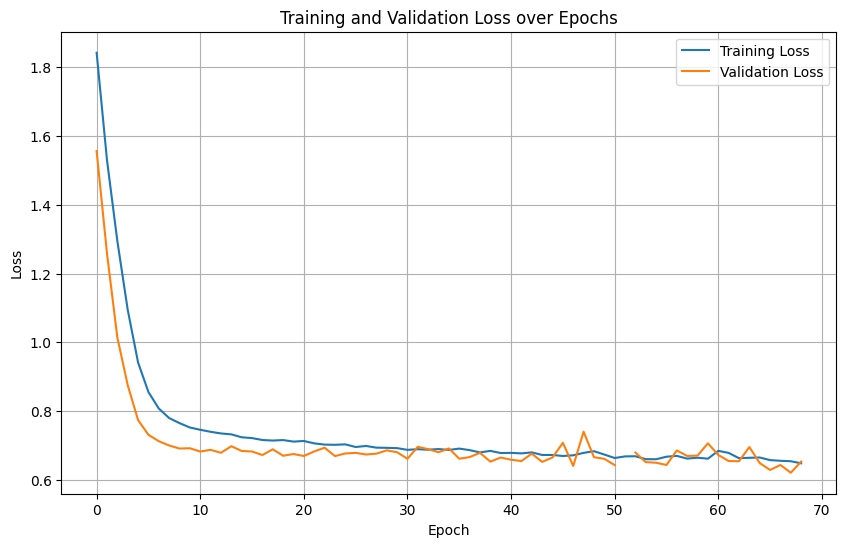

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(0, len(val_losses)), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Plot Dice Score over Epochs**

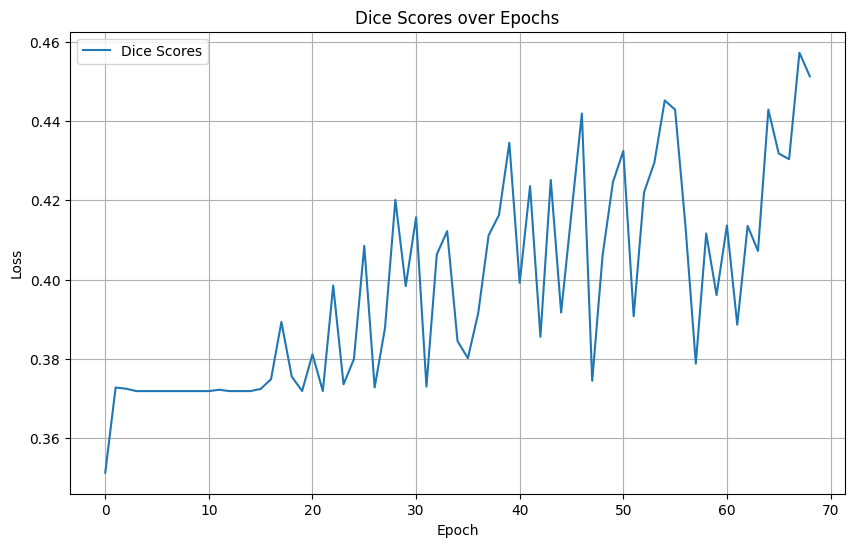

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(dice_scores)), dice_scores, label='Dice Scores')
plt.title('Dice Scores over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Plot Predicted Samples**

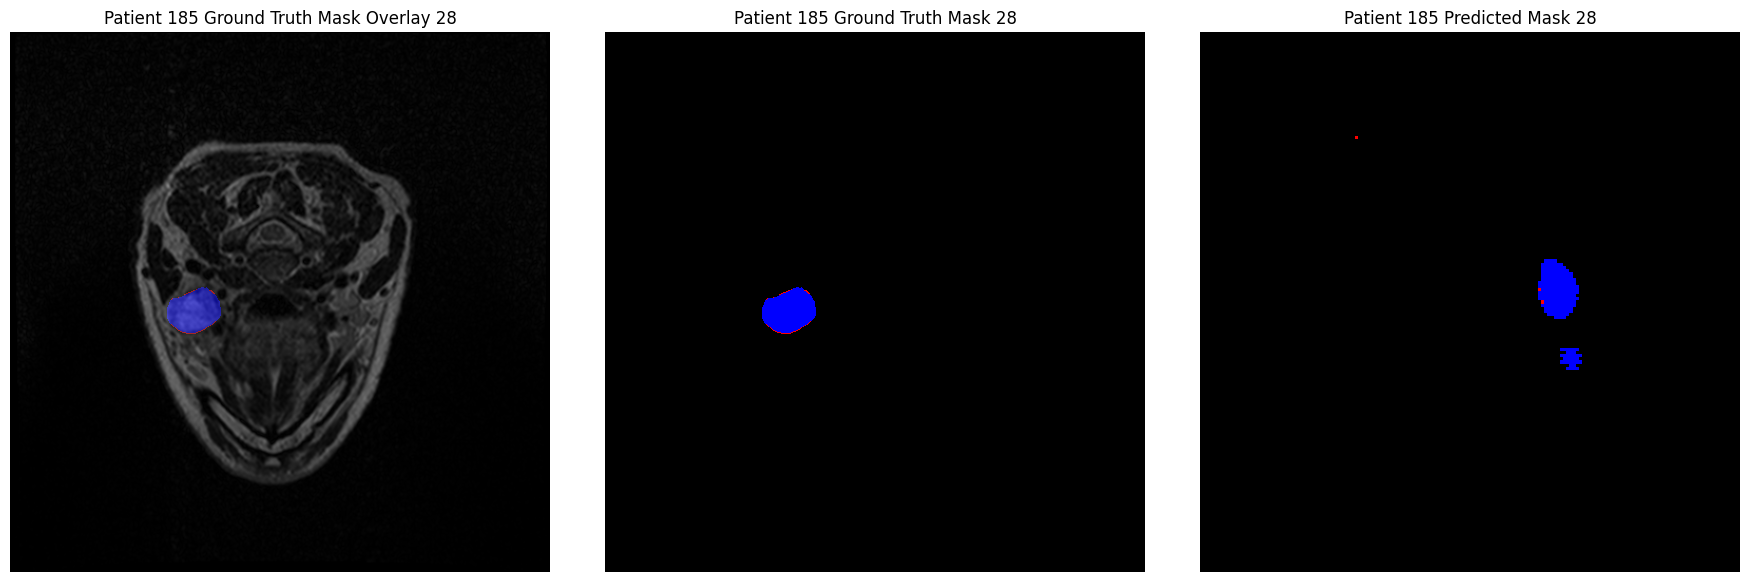

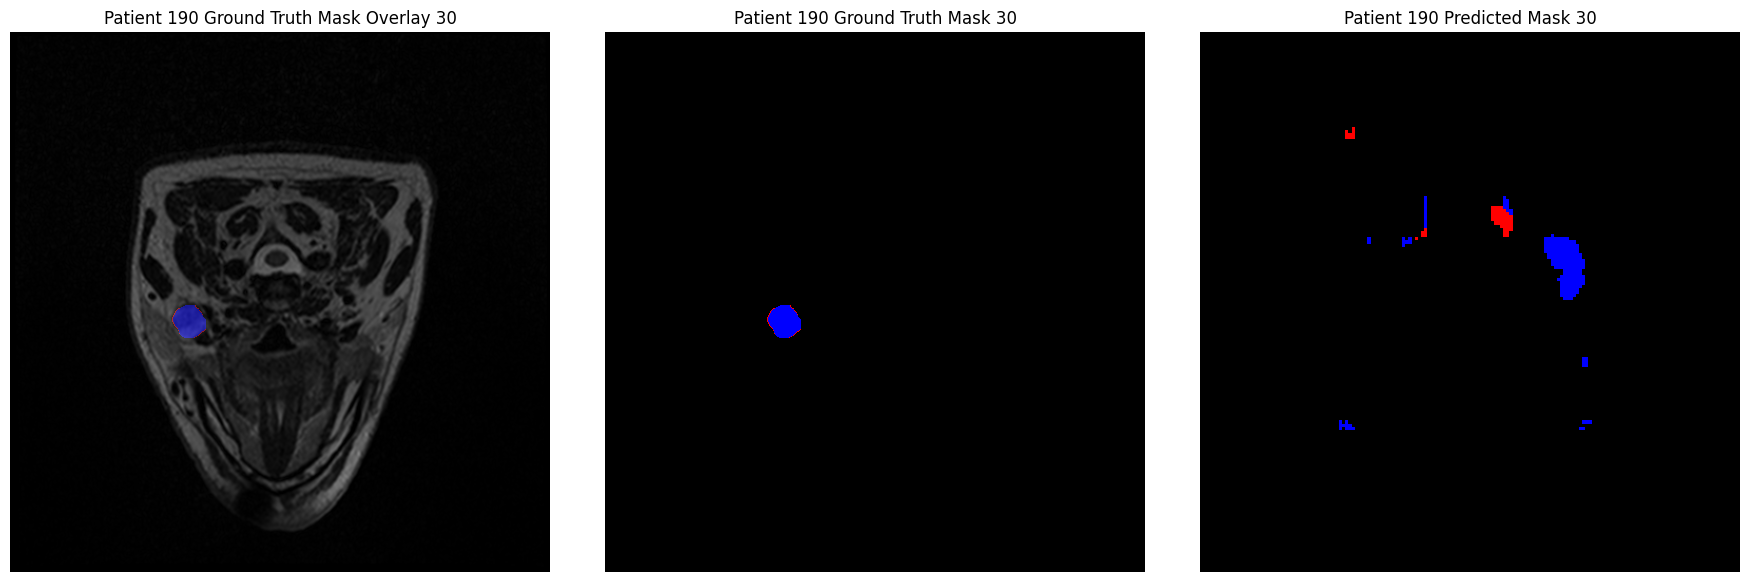

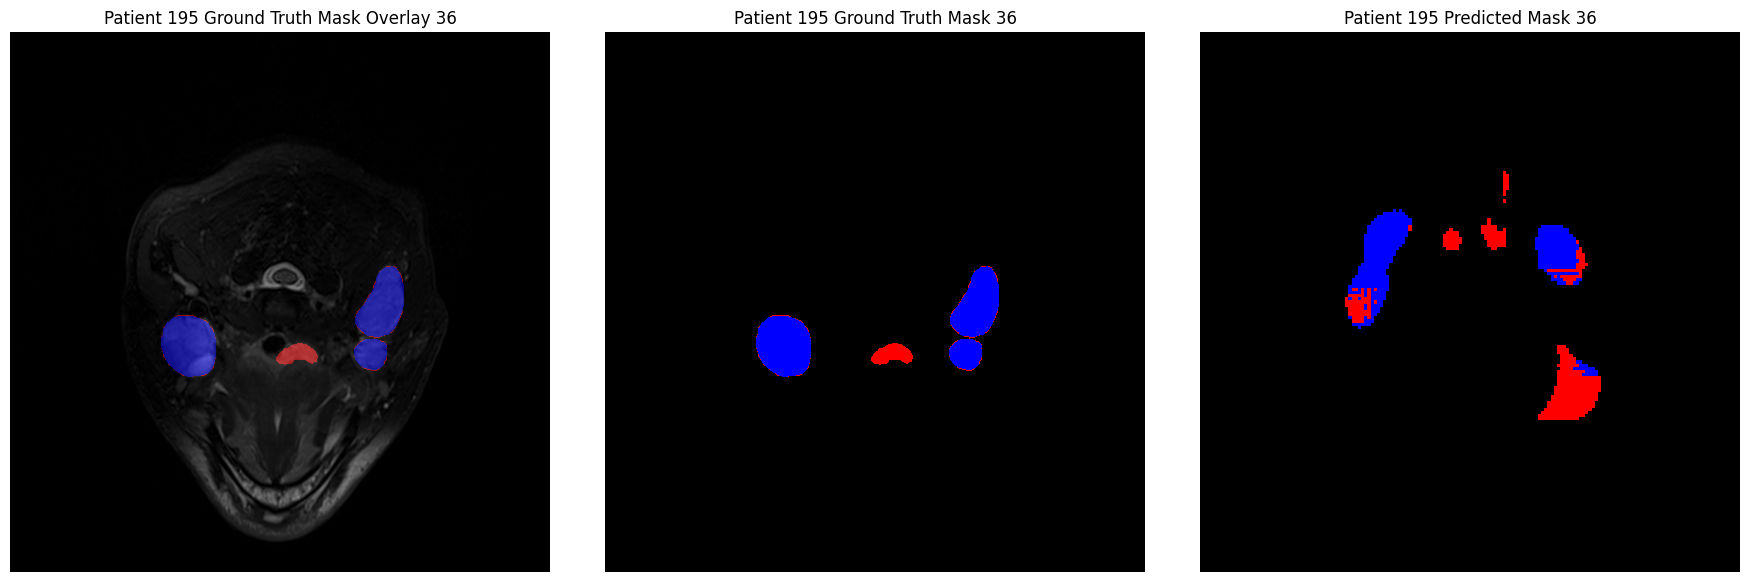

In [31]:
def plot_prediction(train_dir, val_transforms, model, patient_id, slice_index=None, device='cpu'):
    # Define paths
    mri_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    
    # Load data
    mri_data = nib.load(mri_path).get_fdata()
    mask_data = nib.load(mask_path).get_fdata().astype(int)
    
    # Select middle slice if not specified
    slice_index = slice_index or mri_data.shape[2] // 2
    mri_slice = mri_data[:, :, slice_index].T
    mask_slice = mask_data[:, :, slice_index].T

    # Preprocess and predict
    model.eval()
    with torch.no_grad():
        processed = val_transforms({"image": mri_path, "label": mask_path})
        with torch.amp.autocast(str(device)):
            input_tensor = processed["image"].unsqueeze(0).to(device)
            output = sliding_window_inference(input_tensor, (96, 96, 96), 4, model)
            probabilities = torch.softmax(output, dim=1)
            predicted = torch.argmax(probabilities, dim=1).squeeze(0).cpu().numpy()
    
    # Extract the predicted slice and transpose
    predicted_slice = predicted[:, :, slice_index].T
    
    # Define colormap for mask
    cmap = colors.ListedColormap(['black', 'red', 'blue'])
    norm = colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Ground Truth Mask Overlay
    axes[0].imshow(mri_slice, cmap='gray', origin='lower')
    axes[0].imshow(mask_slice, cmap=cmap, norm=norm, alpha=0.5, origin='lower')
    axes[0].set_title(f'Patient {patient_id} Ground Truth Mask Overlay {slice_index}')
    axes[0].axis('off')

    # 2. Ground Truth Mask
    axes[1].imshow(mask_slice, cmap=cmap, norm=norm, origin='lower')
    axes[1].set_title(f'Patient {patient_id} Ground Truth Mask {slice_index}')
    axes[1].axis('off')
    
    # 3. Predicted Mask
    axes[2].imshow(predicted_slice, cmap=cmap, norm=norm, origin='lower')
    axes[2].set_title(f'Patient {patient_id} Predicted Mask {slice_index}')
    axes[2].axis('off')
    
    # Adjust layout to make room for the legend
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Ensure the model is on the correct device
model.to(device)

# Plot samples from a few patients
patient_ids = ['185', '190', '195']
for pid in patient_ids:
    plot_prediction(TRAIN_DIR, val_transforms, model, patient_id=pid, device=device)